In [5]:
%matplotlib inline

In [1]:
import cv2
from utils.imageprocessing import *
from sklearn.cluster import KMeans
import colorsys

In [2]:
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    # return the histogram
    return hist

def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

In [9]:
def Extract_background_mask(image, drawhist=True):
    # convert RGB 2 Gray
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_floodFill = image_gray.copy()

    # make mask
    h, w = image_gray.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # floodFill
    cv2.floodFill(img_floodFill, mask, (0,0), 0, flags = cv2.FLOODFILL_MASK_ONLY)
    
    mask = mask[1:-1, 1:-1]
    
    if drawhist:
        plt.grid(False)
        plt.imshow(mask, cmap="gray") 
        plt.yticks([])
        plt.xticks([])
        plt.show()
    return mask

In [10]:
def Extract_color(image, k = 3, drawhist=True):
    # make background mask
    mask = Extract_background_mask(image, drawhist)
    
    # 색상 클러스터링
    flat_image = image.reshape(image.shape[0] * image.shape[1], 3)
    flat_mask = mask.reshape(image.shape[0] * image.shape[1])
    
    idx = np.where(flat_mask != 1)
    flat_image = flat_image[idx[0]]
    
    clt = KMeans(n_clusters = k)
    clt.fit(flat_image)

    hist = centroid_histogram(clt)
    color = clt.cluster_centers_
    
    # sort hist and color by descending hist
    sort_idx= np.argsort(hist)[::-1]
    hist_sort = [hist[idx] for idx in sort_idx]
    color_sort = [color[idx] for idx in sort_idx]
    
    if drawhist:# draw color bar
        bar = plot_colors(hist_sort, color_sort)
        plt.figure()
        plt.axis("off")
        plt.imshow(bar)
        plt.show()
    
    return hist_sort, color_sort

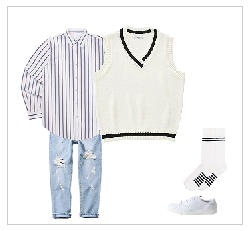

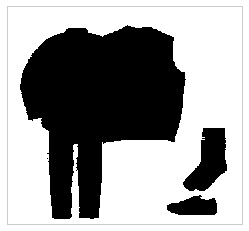

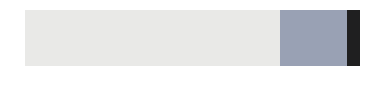

In [12]:
image_path = "1.jpeg"

#preview image
image = cv2.imread(image_path)  
#이미지 변환
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#이미지 사이즈 조정
image = cv2.resize(image, None, fx=1/4, fy=1/4, interpolation = cv2.INTER_CUBIC)
plt.grid(False)
plt.imshow(image)
plt.yticks([])
plt.xticks([])
plt.show()

hist, color = Extract_color(image, 3)
bar = plot_colors(hist, color)

In [9]:
imgs = !ls image/img/codis

In [16]:
def rgb2hsv(r, g, b):
    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = df/mx
    v = mx
    return np.array([h, s, v])

In [17]:
row=[]
for img_path in imgs:
    path = 'image/img/codis/{}'.format(img_path) 
    
    img = cv2.imread(path)   
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #이미지 사이즈 조정
    img = cv2.resize(img, None, fx=1/4, fy=1/4, interpolation = cv2.INTER_CUBIC)
    
    hist, color = Extract_color(img, 3, False)
    
    id_codi = img_path.split('.')[0]

    hsv1 = rgb2hsv(color[0][0], color[0][1], color[0][2])
    hsv2 = rgb2hsv(color[1][0], color[1][1], color[1][2])
    hsv3 = rgb2hsv(color[2][0], color[2][1], color[2][2])
    
    
    row.append([id_codi,hist[0],color[0][0],color[0][1],color[0][2],hsv1[0],hsv1[1],hsv1[2],
                        hist[1],color[1][0],color[1][1],color[1][2],hsv2[0],hsv2[1],hsv2[2],
                        hist[2],color[2][0],color[2][1],color[2][2],hsv3[0],hsv3[1],hsv3[2]])


In [18]:
codis_info = pd.DataFrame(row, columns=['name', 
       'color1_ratio','color1_R','color1_G','color1_B',"color1_H", "color1_S", "color1_V",
       'color2_ratio','color2_R','color2_G','color2_B',"color2_H", "color2_S", "color2_V", 
       'color3_ratio','color3_R','color3_G','color3_B',"color3_H", "color3_S", "color3_V"])

In [19]:
codis_info.to_csv('data/codis_info.csv', index=False)

In [20]:
codis_info

,name,color1_ratio,color1_R,color1_G,color1_B,color1_H,color1_S,color1_V,color2_ratio,color2_R,...,color2_H,color2_S,color2_V,color3_ratio,color3_R,color3_G,color3_B,color3_H,color3_S,color3_V
0,395456,0.551991,19.320905,74.595451,101.896916,199.837334,0.810388,0.399596,0.333034,118.239044,...,214.511815,0.269768,0.634980,0.114975,225.549086,231.383136,234.056347,198.853620,0.036347,0.917868
1,395457,0.366889,235.853713,237.499254,243.467044,227.031633,0.031270,0.954773,0.354360,9.342645,...,216.527696,0.916439,0.438454,0.278750,111.742195,129.048105,134.951698,195.261662,0.171984,0.529222
2,395458,0.479153,29.906952,32.739913,34.298083,201.290686,0.128028,0.134502,0.327135,91.206920,...,208.477727,0.330124,0.533941,0.193712,242.472949,243.433101,245.646015,221.844349,0.012917,0.963318
3,395459,0.454407,251.017751,250.918482,250.725811,39.598121,0.001163,0.984383,0.334314,39.300630,...,91.225767,0.207809,0.172809,0.211279,98.980089,98.583512,67.683561,59.239704,0.316190,0.388157
4,395460,0.438510,125.794521,27.660428,34.185092,356.010766,0.780114,0.493312,0.397817,49.913950,...,289.895157,0.036079,0.196938,0.163673,228.921261,229.310303,230.060820,219.516178,0.004953,0.902199
5,395461,0.564824,228.989836,183.389594,94.263961,39.691989,0.588349,0.897999,0.271522,229.246604,...,52.349529,0.008264,0.899006,0.163655,27.741960,28.178146,29.447075,224.651370,0.057904,0.115479
6,395463,0.410506,172.257959,164.354557,141.832709,44.414126,0.176626,0.675521,0.335490,235.219591,...,43.475466,0.031318,0.922430,0.254004,102.080958,105.146028,82.766456,68.217502,0.212843,0.412337
7,395464,0.417990,254.391681,254.442625,254.259147,76.659574,0.000721,0.997814,0.398211,29.463134,...,273.622960,0.129481,0.122516,0.183799,213.245586,212.959611,212.062629,45.495248,0.005547,0.836257
8,395465,0.411705,150.240283,155.176877,158.094862,202.290064,0.049683,0.619980,0.325783,233.415279,...,86.501124,0.007909,0.918563,0.262512,44.615504,60.897674,76.517829,209.377460,0.416927,0.300070
9,395468,0.584375,34.520261,45.423648,48.089008,191.786024,0.282159,0.188584,0.224236,181.933808,...,47.155993,0.354993,0.713466,0.191389,223.246003,221.786701,228.020712,254.045232,0.027340,0.894199
